In [1]:
# import requirement libraries and tools
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import warnings
warnings.filterwarnings('ignore')
import cv2

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:10<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [4]:
# Set the path to the dataset
dataset_path = '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):

    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        # Store the label for the image in the labels list
        labels.append(subfolder)

 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

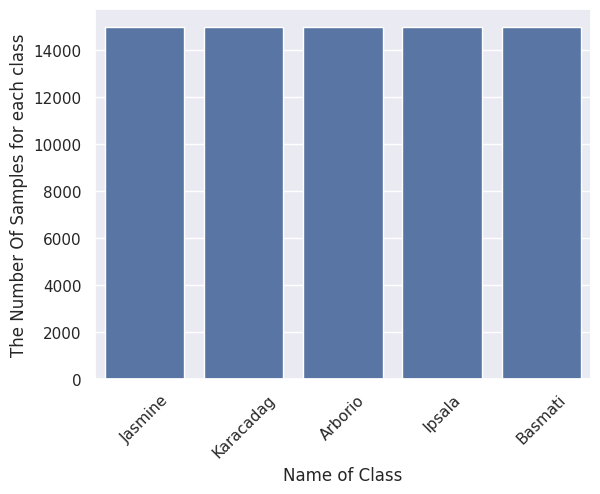

In [5]:
# plot the classes
ax = sns.countplot(x=df.label)

# Set labels and titles
ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

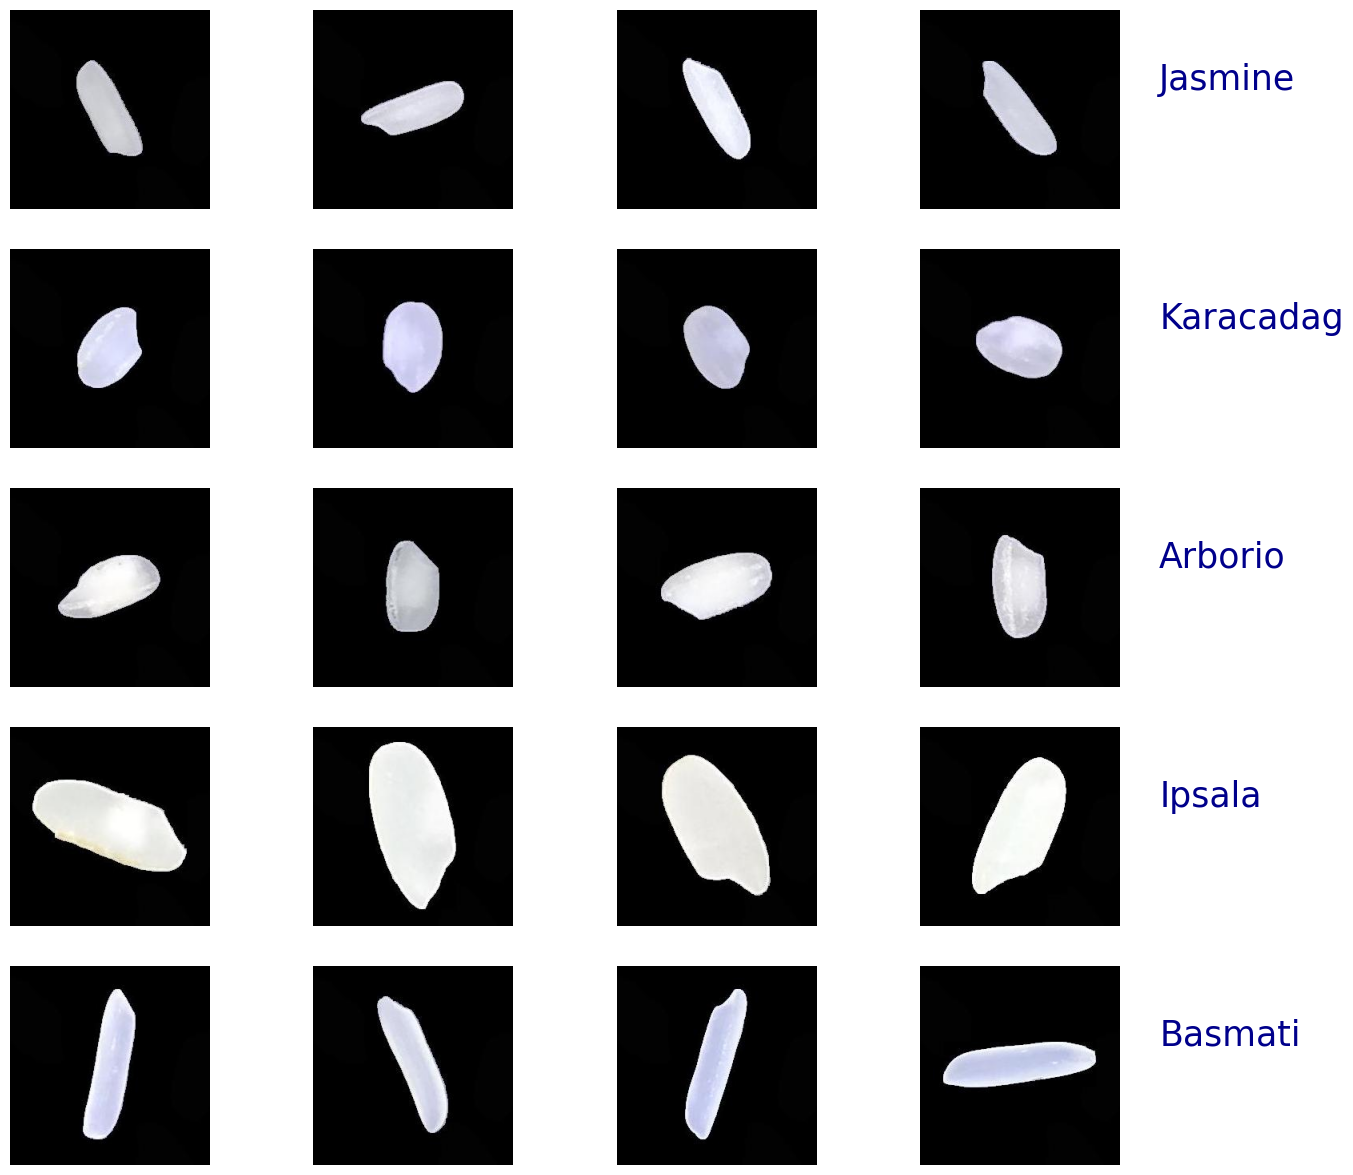

In [6]:
from matplotlib.gridspec import GridSpec
# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]

    # Loop through the filepaths and add an image to each subplot
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')

    # Add a label to the bottom of the subplot grid
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

In [7]:
img = cv2.imread(str(df['image'][0])) # Converting it into numerical arrays
img.shape # Its currently 250 by 250 by 3

(250, 250, 3)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Create a dataframe for the training data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})

# Create a dataframe for the test data
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (50, 50)
batch_size = 128

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Train the model on the training data
history = model.fit(train_generator,epochs=5,validation_data=test_generator)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 230ms/step - accuracy: 0.6808 - loss: 0.7589 - val_accuracy: 0.9337 - val_loss: 0.1855
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9222 - loss: 0.2046Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.9460 - loss: 0.1467 - val_accuracy: 0.9622 - val_loss: 0.1034
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 232ms/step - accuracy: 0.9577 - loss: 0.1182 - val_accuracy: 0.9539 - val_loss: 0.1277
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - accuracy: 0.9642 - loss: 0.0975 - val_accuracy: 0.9683 - val_loss: 0.0863


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
